# Classification de Paresse avec EfficientNet B7

En travaillant avec un ami, j'ai remarqué que ma productivité augmentait lorsque je me sentais "surveillé" par quelqu'un. 

<img src="images/working.jpg" style="width:460px;height:220px;">

Face à cette observation, j'ai eu l'idée de créer un système informatique capable de surveiller et de détecter si une personne est en train de travailler ou non. Ce notebook utilise le modèle **EfficientNet B7**, que je fine-tune pour classifier des images en deux catégories :


- **working** : Personnes travaillant sur un ordinateur portable.
- **not working**:  Personnes utilisant un téléphone ou dans d’autres situations non laborieuses.

Le but est de développer un classifieur binaire capable de différencier entre "working" et "not working".


## Étape 1 - Bibliothèques

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomBrightness, RandomZoom, RandomContrast




### 1.1 Création du dataset et séparation en entrainement et validation 

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

directory = "dataset/base"

# D'abord, nous faisons un split pour obtenir train+validation et test
train_val_dataset = image_dataset_from_directory(directory,
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 image_size=IMG_SIZE,
                                                 validation_split=0.25,  # 25% pour validation+test
                                                 subset='training',
                                                 seed=42)

test_dataset = image_dataset_from_directory(directory,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            validation_split=0.25,  # Le même split pour test
                                            subset='validation',
                                            seed=42)

# Ensuite, nous faisons un split sur train+validation pour les séparer
validation_dataset = train_val_dataset.take(int(0.2 * len(train_val_dataset)))
train_dataset = train_val_dataset.skip(int(0.2 * len(train_val_dataset)))

Found 390 files belonging to 2 classes.
Using 293 files for training.
Found 390 files belonging to 2 classes.
Using 97 files for validation.


### Aperçue des annotations

**Note:** J'ai dû créer le dataset moi-même, certaines images peuvent être mal étiquetées.

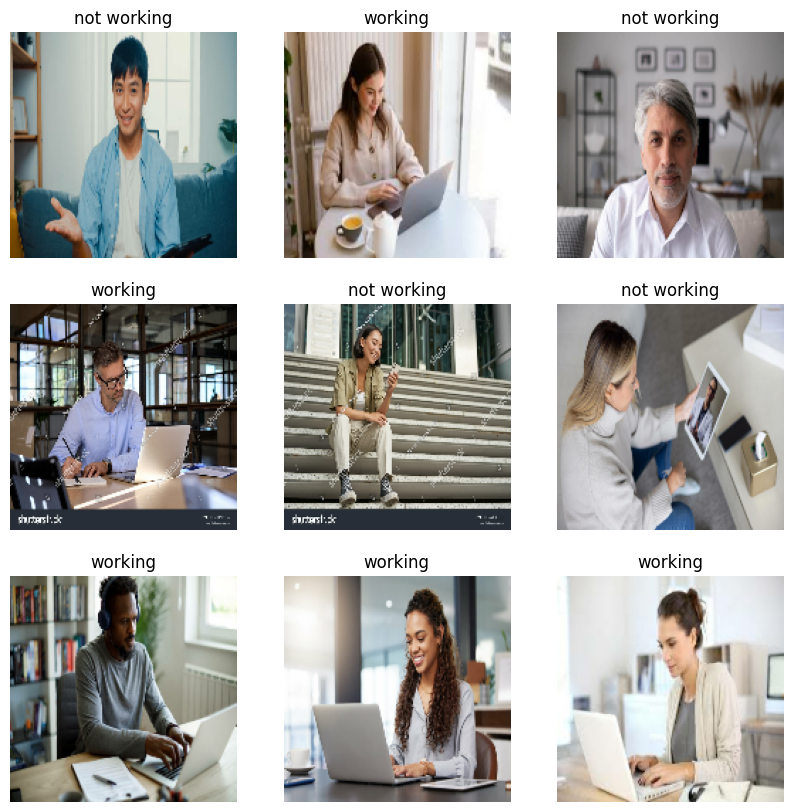

In [4]:
class_names = train_val_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Étape 2 - Prétraitement et Augmentation des Données

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
def data_augmenter():
    '''
    Création d'un modèle séquentiel composé de 5 couches d'augmentation.
    Returns:
        tf.keras.Sequential
    '''
    
    data_augmentation = tf.keras.Sequential([
        RandomFlip('horizontal_and_vertical'), 
        RandomRotation(0.2),
        RandomBrightness(0.2),
        RandomZoom(0.2),
        RandomContrast(0.1)
    ])
    return data_augmentation

Aperçu des données augmenté 

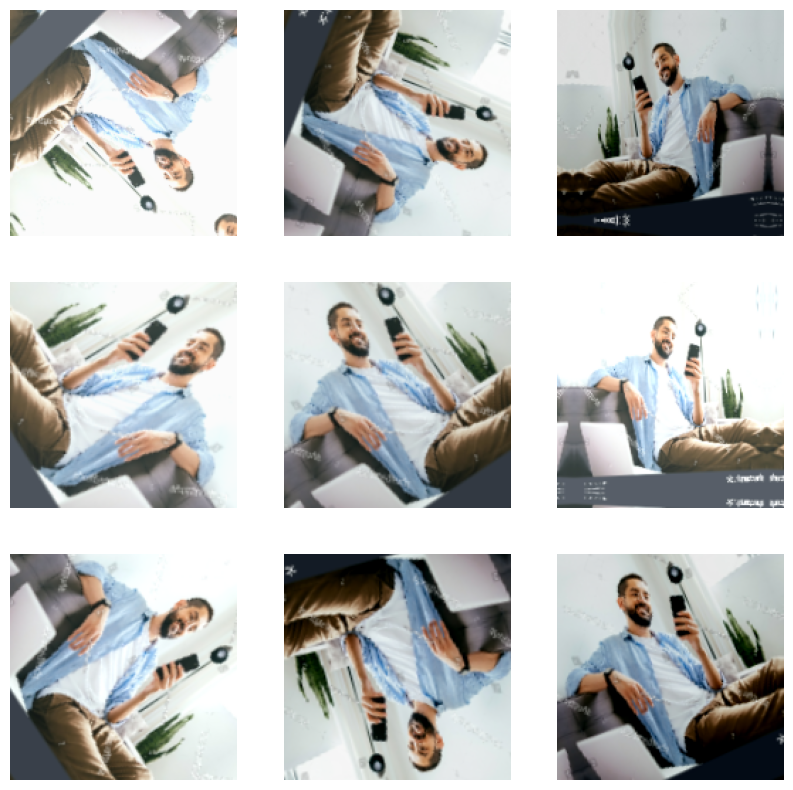

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Création du model basé sur EfficientNet B7

In [8]:
# Prétraitement des données d'entrée avec la méthode associée à EfficientNet
preprocess_input_2 = tf.keras.applications.efficientnet.preprocess_input

# Définir la forme des images en entrée en ajoutant la dimension des canaux (3 pour RGB)
input_shape = IMG_SIZE + (3,)

# Charger le modèle de base EfficientNetB7 pré-entraîné sur ImageNet
base_model = tf.keras.applications.EfficientNetB7(input_shape=input_shape,
                                                  include_top=False, 
                                                  weights='imagenet')

# Geler le modèle de base en le rendant non entraînable
base_model.trainable = False

# Créer la couche d'entrée pour le modèle
inputs = tf.keras.Input(shape=input_shape) 

# Appliquer les augmentations de données aux images d'entrée
x = data_augmentation(inputs)

# Prétraiter les données en utilisant les mêmes paramètres que ceux utilisés pour entraîner le modèle EfficientNet
x = preprocess_input_2(x) 

# Passer les données prétraitées à travers le modèle de base
x = base_model(x, training=False) 

# Ajouter une couche de GlobalAveragePooling2D pour résumer les informations de chaque canal
x = tfl.GlobalAveragePooling2D()(x)

# Ajouter une couche Dropout avec une probabilité de 0.5 pour éviter le surapprentissage
x = tfl.Dropout(0.5)(x)

# Ajouter une couche avec 128 neurones et la fonction d'activation ReLU
x = tfl.Dense(128, activation='relu')(x)

# Ajouter une autre couche Dropout avec une probabilité de 0.5
x = tfl.Dropout(0.5)(x)

# Ajouter une couche de sortie avec un neurone pour la classification binaire
outputs = tfl.Dense(1, activation='sigmoid')(x)

# Créer le modèle final en connectant les entrées et les sorties
model = tf.keras.Model(inputs, outputs)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 5, 5, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,425,624 (245.76 MB)

 Trainable params: 327,937 (1.25 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [10]:
# Définir le taux d'apprentissage initial pour l'optimiseur
base_learning_rate = 0.001

# Compiler le modèle avec l'optimiseur, la fonction de perte et les métriques
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [11]:
# Nombre d'époques pour l'entraînement initial du modèle
initial_epochs = 11

# Entraînement du modèle sur les données d'entraînement
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/11
8/8 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.5226 - loss: 0.7607 - val_accuracy: 0.8438 - val_loss: 0.5076
Epoch 2/11
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6578 - loss: 0.5995 - val_accuracy: 0.9219 - val_loss: 0.4071
Epoch 3/11
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7612 - loss: 0.5527 - val_accuracy: 0.8125 - val_loss: 0.4427
Epoch 4/11
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7573 - loss: 0.5172 - val_accuracy: 0.8438 - val_loss: 0.3775
Epoch 5/11
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7537 - loss: 0.5364 - val_accuracy: 0.8125 - val_loss: 0.4626
Epoch 6/11
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7287 - loss: 0.5567 - val_accuracy: 0.8594 - val_loss: 0.3831
Epoch 7/11
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7490 - loss: 0.5167 - val_accuracy: 0.8438 - val_loss: 0.3460
Epoch 8/11
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7147 - loss: 0.5158 - val_accuracy: 0.8125 - val_loss: 0.4159
Epoch 9/

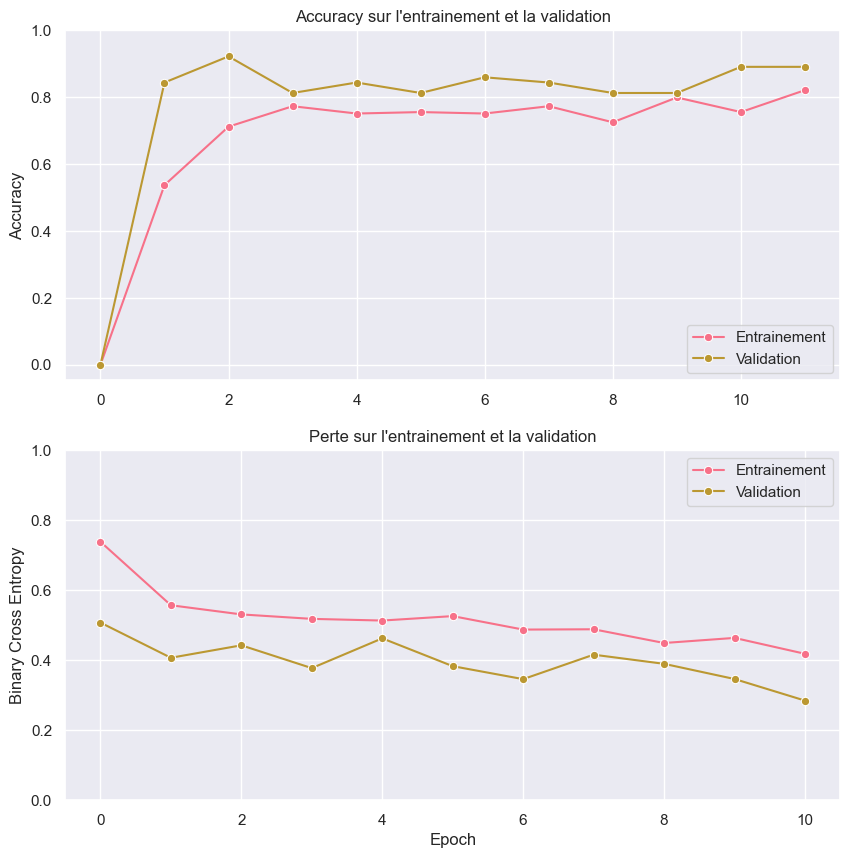

In [12]:
# Définir un style et une palette de couleurs avec Seaborn
sns.set_theme(style="darkgrid")
sns.set_palette("husl")

# Récupérer les données d'accuracy et de perte de l'entrainement
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Créer le graphique avec deux sous-graphiques (accuracy et loss)
plt.figure(figsize=(10, 10))

# Sous-graphe pour l'accuracy
plt.subplot(2, 1, 1)
sns.lineplot(x=range(len(acc)), y=acc, label='Entrainement', marker='o')
sns.lineplot(x=range(len(val_acc)), y=val_acc, label='Validation', marker='o')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Accuracy sur l\'entrainement et la validation')

# Sous-graphe pour la perte
plt.subplot(2, 1, 2)
sns.lineplot(x=range(len(loss)), y=loss, label='Entrainement', marker='o')
sns.lineplot(x=range(len(val_loss)), y=val_loss, label='Validation', marker='o')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Perte sur l\'entrainement et la validation')
plt.xlabel('Epoch')

# Afficher le graphique
plt.show()


Le modèle semble stagner dans son apprentissage, nous dégelerons donc les dernières couches pour essayer de le rendre plus performant.

In [13]:
# Définir l'indice à partir duquel les couches seront "dégelées" pour le fine-tuning
fine_tune_at = 750  

# Récupérer le modèle de base depuis la couche 2 du modèle créé plus tôt et le rendre entraînable
base_model = model.layers[2]  
base_model.trainable = True  

# Geler toutes les couches avant 'fine_tune_at' pour préserver les poids pré-entraînés
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False  

# Définir le taux d'apprentissage de base pour la phase de fine-tuning
base_learning_rate = 0.001 

# Configurer l'optimiseur avec un taux d'apprentissage réduit
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)

# Compiler le modèle avec la fonction de perte, l'optimiseur et les métriques spécifiés
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])

# Vérifier et afficher les couches qui seront entraînables
print(f"Nombre de couches dans le modèle de base : {len(base_model.layers)}")
print(f"Couches dégivrées : {fine_tune_at} et suivantes")

Nombre de couches dans le modèle de base : 814
Couches dégivrées : 750 et suivantes


In [14]:
# Définir le nombre d'époques pour la phase de fine-tuning
fine_tune_epochs = 13

# Calculer le nombre total d'époques en ajoutant les époques d'origine et celles de fine-tuning
total_epochs = initial_epochs + fine_tune_epochs

# Continuer l'entraînement du modèle avec fine-tuning
history_fine = model.fit(train_dataset,                    
                         epochs=total_epochs,              
                         initial_epoch=history.epoch[-1],  
                         validation_data=validation_dataset)

Epoch 11/24


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.7639 - loss: 0.4819 - val_accuracy: 0.8594 - val_loss: 0.3417
Epoch 12/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.7550 - loss: 0.4910 - val_accuracy: 0.8594 - val_loss: 0.3476
Epoch 13/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.7846 - loss: 0.4867 - val_accuracy: 0.8750 - val_loss: 0.3082
Epoch 14/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8638 - loss: 0.3764 - val_accuracy: 0.8438 - val_loss: 0.3601
Epoch 15/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8389 - loss: 0.3928 - val_accuracy: 0.8281 - val_loss: 0.3437
Epoch 16/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8612 - loss: 0.3369 - val_accuracy: 0.8594 - val_loss: 0.3559
Epoch 17/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8394 - loss: 0.3467 - val_accuracy: 0.8906 - val_loss: 0.2910
Epoch 18/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8454 - loss: 0.3868 - val_accuracy: 0.8750 - val_loss: 0.3448
Epoch 19/24


In [15]:
# Ajouter les historiques du fine-tuning aux historiques existants
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

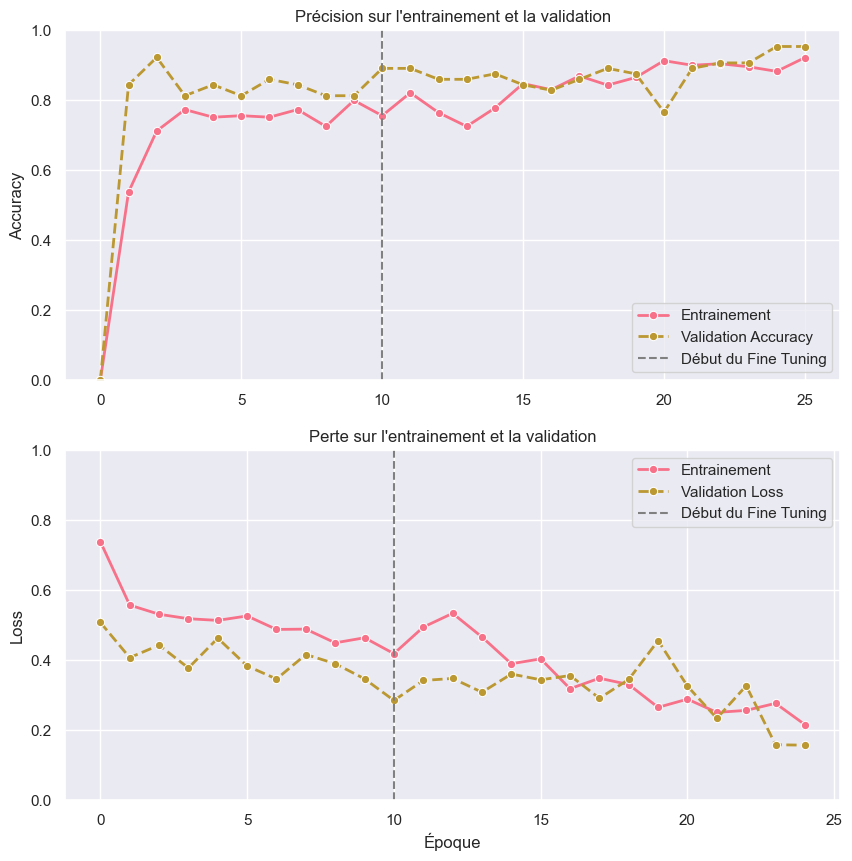

In [16]:
# Créer le graphique avec deux sous-graphiques (accuracy et loss)
plt.figure(figsize=(10, 10))  

# Sous-graphe pour la précision
plt.subplot(2, 1, 1)  
sns.lineplot(x=range(len(acc)), y=acc, label='Entrainement', marker='o', linestyle='-', linewidth=2)
sns.lineplot(x=range(len(val_acc)), y=val_acc, label='Validation Accuracy', marker='o', linestyle='--', linewidth=2)
plt.axvline(x=initial_epochs - 1, color='gray', linestyle='--', label='Début du Fine Tuning')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Précision sur l\'entrainement et la validation')
plt.ylabel('Accuracy')

# Sous-graphe pour la perte
plt.subplot(2, 1, 2)  
sns.lineplot(x=range(len(loss)), y=loss, label='Entrainement', marker='o', linestyle='-', linewidth=2)
sns.lineplot(x=range(len(val_loss)), y=val_loss, label='Validation Loss', marker='o', linestyle='--', linewidth=2)
plt.axvline(x=initial_epochs - 1, color='gray', linestyle='--', label='Début du Fine Tuning')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Perte sur l\'entrainement et la validation') 
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.show()

In [20]:
# Sauvegarder le modèle complet en format TensorFlow SavedModel
model.export('model/Flemardise_V1')

INFO:tensorflow:Assets written to: model/Flemardise_V1\assets


INFO:tensorflow:Assets written to: model/Flemardise_V1\assets


Saved artifact at 'model/Flemardise_V1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_820')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2830929465744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2830929465936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2830929466128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2830929466320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2830929466512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2830929472080: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2830929469968: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2830929471120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2830929472464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2830929472848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  283092947

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


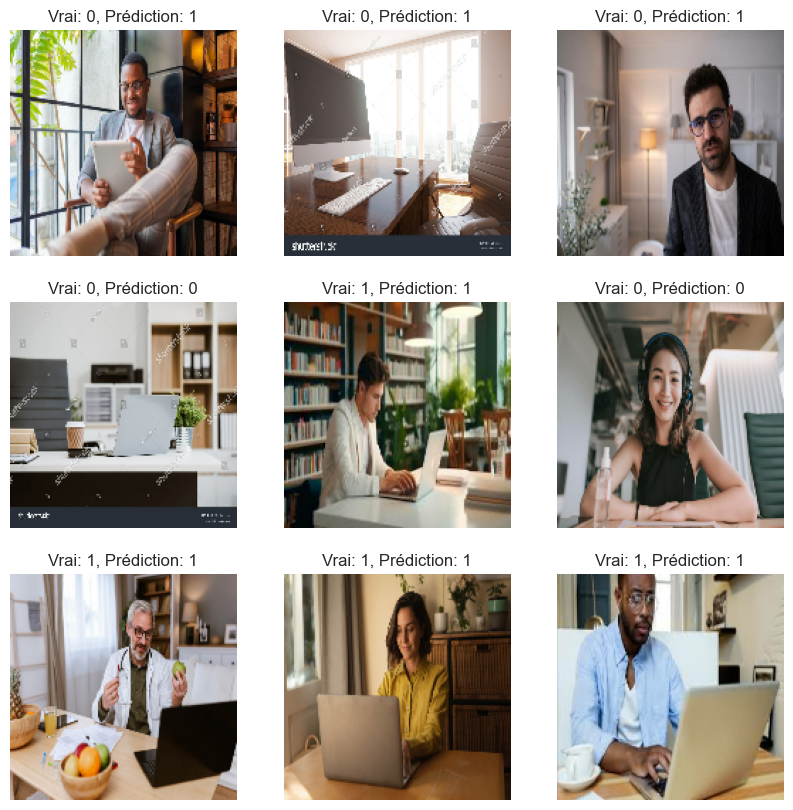

In [17]:
# Prédire et afficher les résultats sur un sous-ensemble de données de test
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_classes = [1 if p > 0.5 else 0 for p in predictions]
    
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Vrai: {labels[i].numpy()}, Prédiction: {predicted_classes[i]}")
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_17544\2382232487.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Prédiction: {int(predicted_class)}")


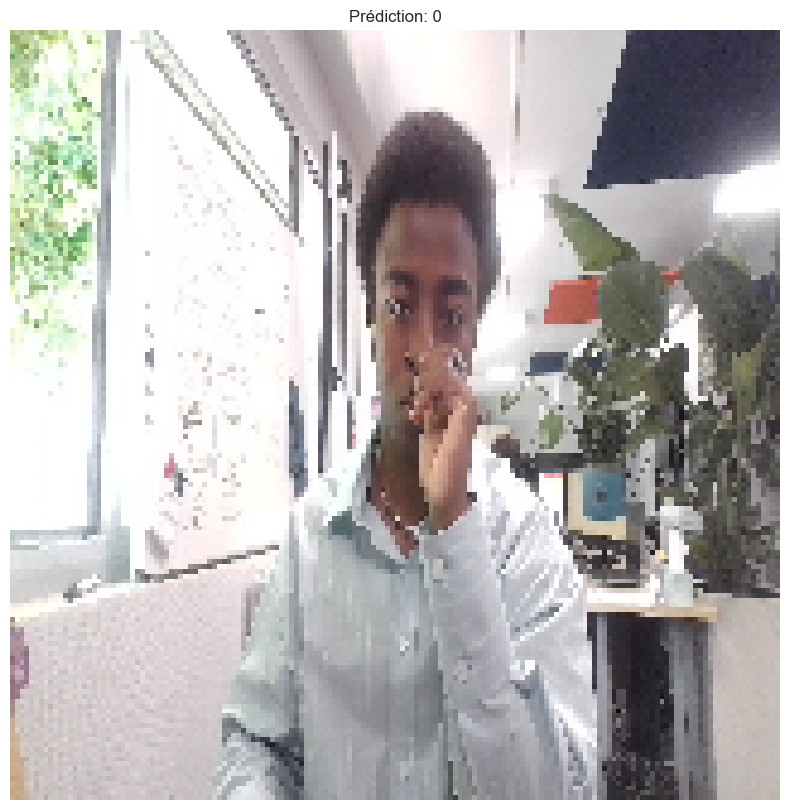

[[0.35334617]]


In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Charger une image pour prédiction
img_path = 'frame_at_50s.jpg'  # Remplace par le chemin de ton image
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  

# Faire la prédiction
predictions = model.predict(img_array)
predicted_class = np.round(predictions)  

# Afficher le résultat
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title(f"Prédiction: {int(predicted_class)}")
plt.axis("off")
plt.show()
print(predictions)

## Conclusion

### Analyse des Résultats

Le projet visait à développer un classifieur capable de distinguer si une personne est en train de travailler ou non, en utilisant le modèle EfficientNet B7. Voici un récapitulatif des résultats obtenus durant l'entraînement et le fine-tuning :

1. **Entraînement Initial :**
   - Après 11 époques d'entraînement initial, le modèle a atteint une précision de **83.3%** sur les données d'entraînement et **89.1%** sur les données de validation.
   - Cependant, nous avons remarqué une stagnation dans l'amélioration de la perte et de la précision, ce qui a conduit à l'étape de fine-tuning.

2. **Phase de Fine-Tuning :**
   - En dégivrant les dernières couches du modèle de base, le modèle a montré une amélioration significative.
   - Après 13 époques supplémentaires de fine-tuning, la précision sur les données de validation a atteint environ **94%**, avec une perte de validation réduite à **0.15**.

Les graphiques de précision et de perte montrent clairement l'amélioration apportée par le fine-tuning.


### Pistes d'Amélioration

1. **Augmentation de la Taille du Dataset :**
   - La performance du modèle pourrait être davantage améliorée en augmentant la taille du dataset d'entraînement. Un dataset plus large et plus varié permettrait au modèle de mieux généraliser.
   
2. **Amélioration de l'Étiquetage des Données :**
   - Comme mentionné, certaines images étaient mal étiquetées. Un étiquetage plus précis pourrait améliorer la précision du modèle.
   - Un cadre plus défini dans les catégories permettrait de mieux performer en clarifiant ce qu'est 'working' et 'not working', afin d'obtenir des données pertinentes pour l'utilisation

3. **Fine-Tuning Plus Profond :**
   - Entraîner une proportion plus grande des couches du modèle de base pourrait permettre une meilleure capture des caractéristiques des images spécifiques à notre dataset.

4. **Métriques d'Évaluation Supplémentaires :**
   - Utiliser d'autres métriques d'évaluation comme la précision, le rappel, le F1-score, et autre permettrait une évaluation plus complète de la performance du modèle.

### Conclusion Générale

Ce projet illustre l'application efficace des techniques de vision par ordinateur et de transfert de connaissance pour résoudre un problème pratique. 
En utilisant **EfficientNet B7**, nous avons réussi à développer un modèle robuste capable de classer les images en deux catégories : "working" et "not working". Les résultats sont prometteurs, avec une précision élevée et une assez bonne généralisation.

Cependant, le manque de cohérence entre les données d'entraînement et celles qui seront collectées en pratique signifie que le modèle ne répondra pas parfaitement au besoin initial de détecter la **flemmardise**. 

En l'état, le modèle a plutôt appris à détecter la présence d'une personne devant son ordinateur, ce qui est un bon début, mais il est encore loin d'atteindre le résultat escompté.
